# Summary statistics

In this notebook we check functions made to measure summary statistics on the output of the forward model.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), os.pardir))
sys.path.append(parent_dir)

import numpy as np
import healpy as hp
import matplotlib.pyplot as plt
import pymaster as nmt
import camb

import summary_statistic as sumstat
from mass_mapping import kaiser_squire

from tqdm import tqdm

In [2]:
#Load an example simulation
path = '/n17data/sguerrini/GowerStreetSims/processed/forward_model_sim00002_nside0512_rot00_noisereal0.npy'

sim = np.load(path, allow_pickle=True).item()

In [3]:
for key, value in sim['cosmo_params'].items():
    print(f'{key}= {value[0]}')

h= 0.7165473754
Omega_m= 0.2496287584
Omega_b= 0.04350883101
sigma_8= 0.9504961601
n_s= 0.9513110688
w= -0.7924174042
m_nu= 0.06
A_s= 3.968190251995511e-09


/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/healpy/projector.py:201: ComplexWarning: Casting complex values to real discards the imaginary part
  img[w] = mpix


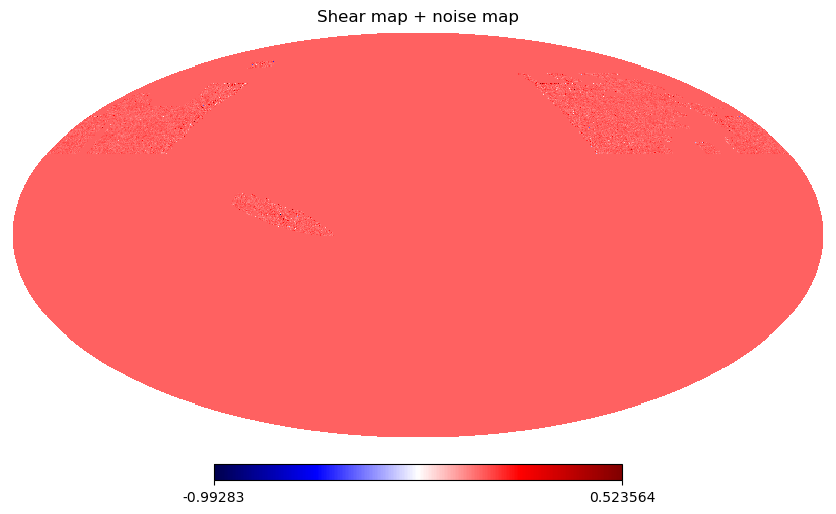

In [4]:
#Get the shear map for the bin 4
shear_idx = sim['bin_4']['masked_shear_map']
noise_idx = sim['bin_4']['noise_map']
idx = sim['bin_4']['idx']

nside = sim['config']['preprocessing']['nside']

shear_map = np.zeros(hp.nside2npix(nside), dtype=np.complex128)
noise_map = np.zeros(hp.nside2npix(nside), dtype=np.complex128)

shear_map[idx] += shear_idx + noise_idx
noise_map[idx] += noise_idx

hp.mollview(shear_map, title='Shear map + noise map', cmap='seismic')
plt.show()

### Pseudo-Cls

In [5]:
ell_eff, cl_shear = sumstat.get_pseudo_cls(shear_map, nside)
ell_eff, cl_noise = sumstat.get_pseudo_cls(noise_map, nside)


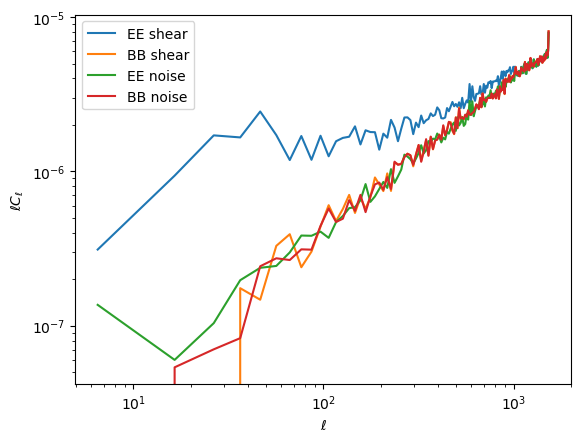

In [6]:
plt.figure()

plt.plot(ell_eff, ell_eff*cl_shear[0], label='EE shear')
plt.plot(ell_eff, ell_eff*cl_shear[3], label='BB shear')
plt.plot(ell_eff, ell_eff*cl_noise[0], label='EE noise')
plt.plot(ell_eff, ell_eff*cl_noise[3], label='BB noise')

plt.xlabel('$\ell$')
plt.ylabel('$\ell C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

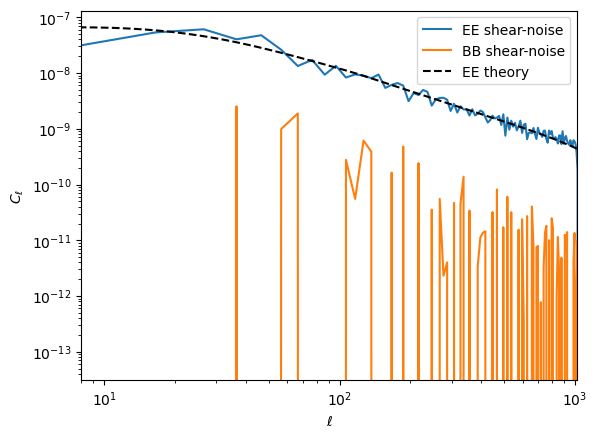

In [7]:
#Check against theory
#Load parameters for the cosmology
h = sim['cosmo_params']["h"]
Om = sim['cosmo_params']["Omega_m"]
Ob = sim['cosmo_params']["Omega_b"]
Oc = Om - Ob
ns = sim['cosmo_params']["n_s"]
m_nu = sim['cosmo_params']["m_nu"]
w = sim['cosmo_params']["w"]
As = sim['cosmo_params']["A_s"]

redshift_distr = np.loadtxt(sim['config']['redshift_distribution']['path_dndz'])

nside=512
lmax = 2*nside

pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)
Onu = pars.omeganu
Oc = Om - Ob - Onu
pars = camb.set_params(H0=100*h, omch2=Oc*h**2, ombh2=Ob*h**2, ns=ns, mnu=m_nu, w=w, As=As, WantTransfer=True, NonLinear=camb.model.NonLinear_both)

#get the angular power spectra of the lensing map
sim_cls = sim['bin_4']['cl_FS_gamma']

z, dndz = redshift_distr[:, 0], redshift_distr[:, 4]

#getthe expected cl's from CAMB
pars.min_l = 1
pars.set_for_lmax(lmax)
pars.SourceWindows = [
    camb.sources.SplinedSourceWindow(z=z, W=dndz, source_type='lensing')
]
theory_cls = camb.get_results(pars).get_source_cls_dict(lmax=lmax, raw_cl=True)

l = np.arange(lmax+1)
pw = hp.pixwin(nside, lmax=lmax)
m_bias = sim['nuisance_parameters']['bin_4']['m_bias']

plt.figure()

plt.plot(ell_eff, cl_shear[0]-cl_noise[0], label='EE shear-noise')
plt.plot(ell_eff, cl_shear[3]-cl_noise[3], label='BB shear-noise')
plt.plot(l, theory_cls['W1xW1']*pw**2*(1+m_bias)**2, label='EE theory', ls='--', color='black')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

plt.legend()

plt.xlim(8, lmax)
plt.xscale('log')
plt.yscale('log')

plt.show()

In [8]:
#Check bandpowers power spectrum
ell_eff_powspace, cl_powspace = sumstat.get_pseudo_cls(shear_map, nside, binning='powspace', power=1/2, n_ell_bins=28)
ell_eff_powspace, cl_noise_powspace = sumstat.get_pseudo_cls(noise_map, nside, binning='powspace', power=1/2, n_ell_bins=28)

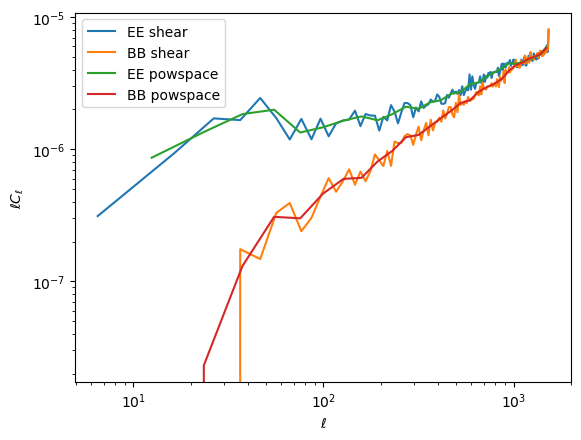

In [9]:
plt.figure()

plt.plot(ell_eff, ell_eff*cl_shear[0], label='EE shear')
plt.plot(ell_eff, ell_eff*cl_shear[3], label='BB shear')
plt.plot(ell_eff_powspace, ell_eff_powspace*cl_powspace[0], label='EE powspace')
plt.plot(ell_eff_powspace, ell_eff_powspace*cl_powspace[3], label='BB powspace')

plt.xlabel('$\ell$')
plt.ylabel('$\ell C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

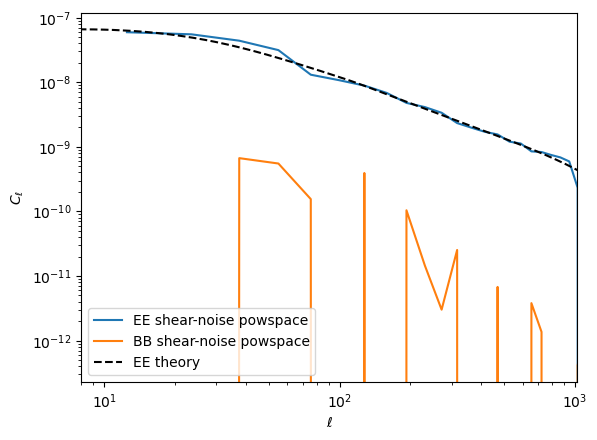

In [10]:
plt.figure()

plt.plot(ell_eff_powspace, cl_powspace[0]-cl_noise_powspace[0], label='EE shear-noise powspace')
plt.plot(ell_eff_powspace, cl_powspace[3]-cl_noise_powspace[3], label='BB shear-noise powspace')
plt.plot(l, theory_cls['W1xW1']*pw**2*(1+m_bias)**2, label='EE theory', ls='--', color='black')

plt.xlabel('$\ell$')
plt.ylabel('$C_\ell$')

plt.legend()

plt.xlim(8, lmax)
plt.xscale('log')
plt.yscale('log')

plt.show()

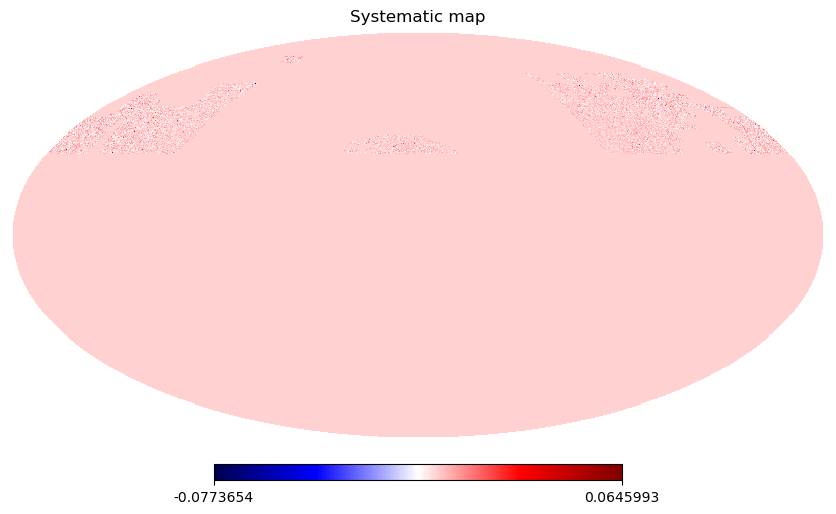

In [11]:
#Influence of the systematic map
systematic_map = np.zeros(hp.nside2npix(nside), dtype=np.complex128)

star_map = sim['bin_4']['sys_map']
idx_star = sim['bin_4']['idx_star']

systematic_map[idx_star] += star_map

hp.mollview(systematic_map, title='Systematic map', cmap='seismic')
plt.show()


In [12]:
ell_eff_powspace, cl_w_stars = sumstat.get_pseudo_cls(shear_map+systematic_map, nside, binning='powspace', power=1/2, n_ell_bins=28)

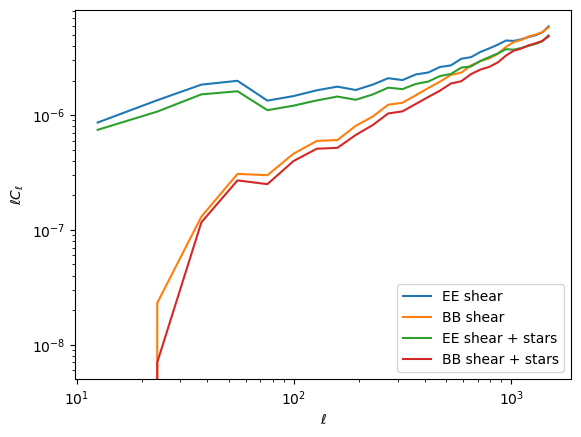

In [13]:
plt.figure()

plt.plot(ell_eff_powspace, ell_eff_powspace*cl_powspace[0], label='EE shear')
plt.plot(ell_eff_powspace, ell_eff_powspace*cl_powspace[3], label='BB shear')
plt.plot(ell_eff_powspace, ell_eff_powspace*cl_w_stars[0], label='EE shear + stars')
plt.plot(ell_eff_powspace, ell_eff_powspace*cl_w_stars[3], label='BB shear + stars')

plt.xlabel('$\ell$')
plt.ylabel('$\ell C_\ell$')

plt.legend()

plt.xscale('log')
plt.yscale('log')

plt.show()

### Peak counts

In [14]:
#get the kappa map
kappa_E, kappa_B = kaiser_squire(shear_map)

/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:200: RuntimeWarning: invalid value encountered in multiply
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: divide by zero encountered in divide
/home/guerrini/.conda/envs/glass/lib/python3.10/site-packages/bornraytrace-0.2-py3.10.egg/bornraytrace/lensing.py:201: RuntimeWarning: invalid value encountered in multiply


In [15]:
smoothing_scales = np.logspace(np.log10(8.2), np.log10(221.), 8)
print(smoothing_scales)

[  8.2         13.12750518  21.01602344  33.64487275  53.8625904
  86.22944322 138.046032   221.        ]


In [16]:
kappa_smooth = []
for scale in smoothing_scales:
    kappa_smooth.append(sumstat.smooth_map(scale, 3*nside, kappa_E, nside))

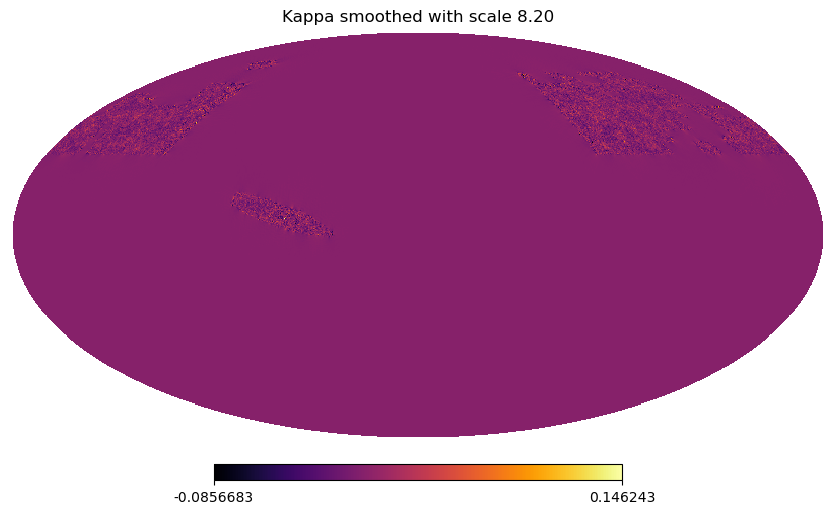

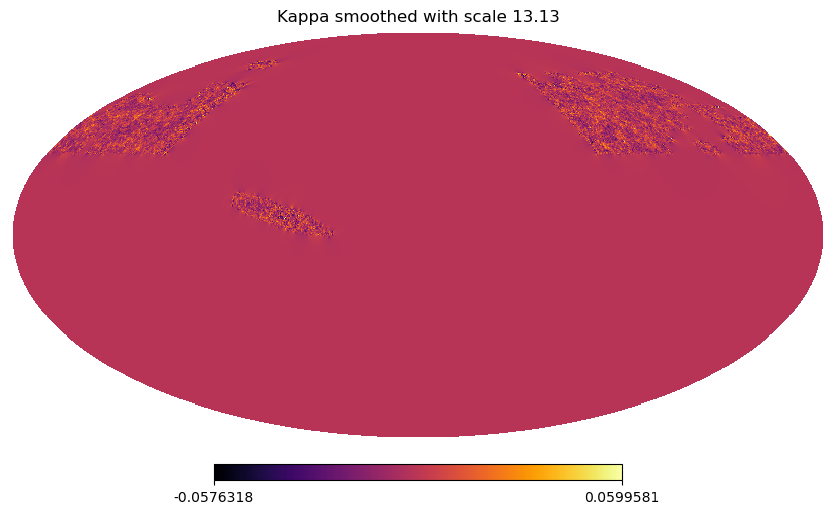

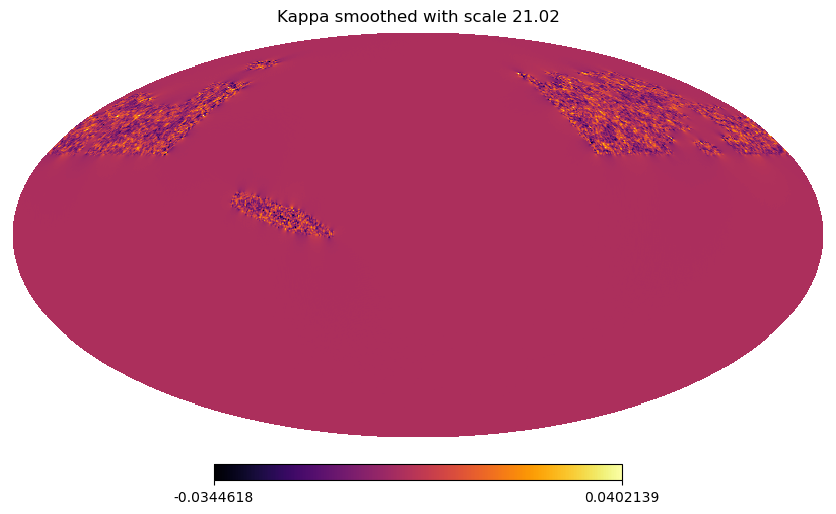

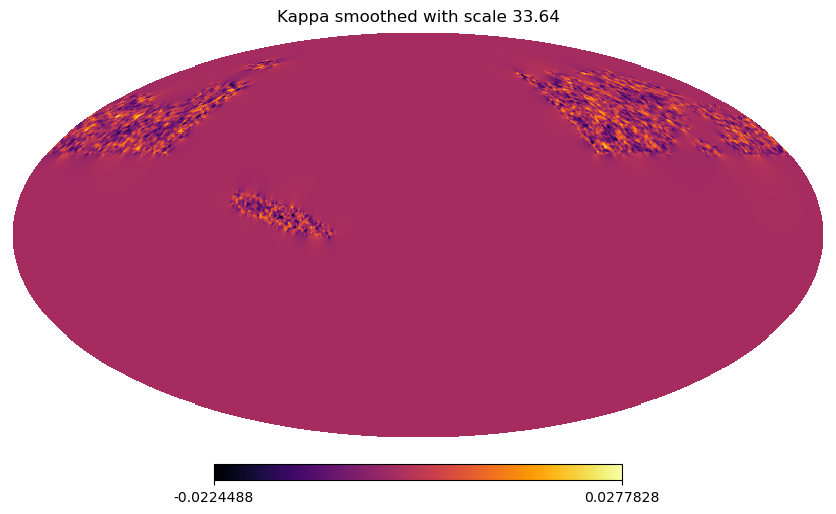

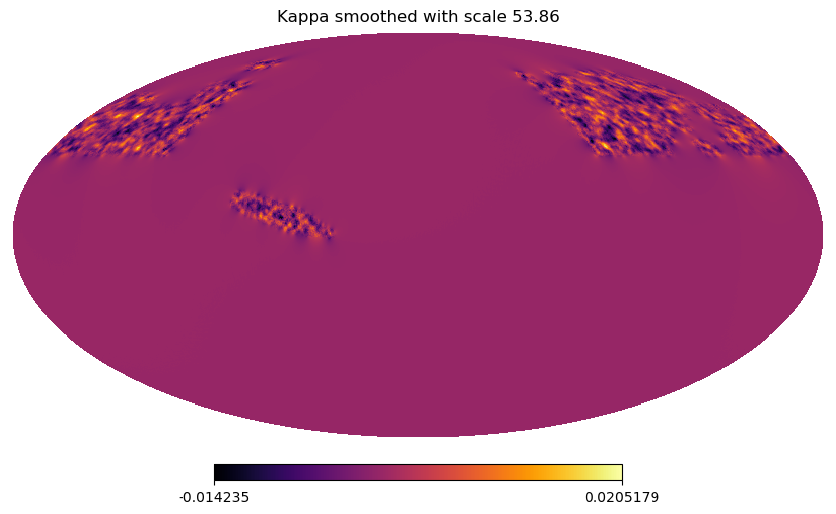

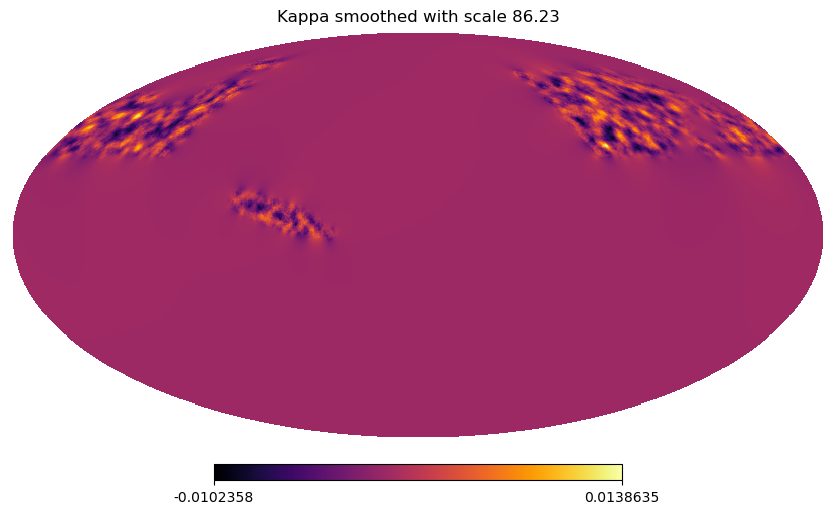

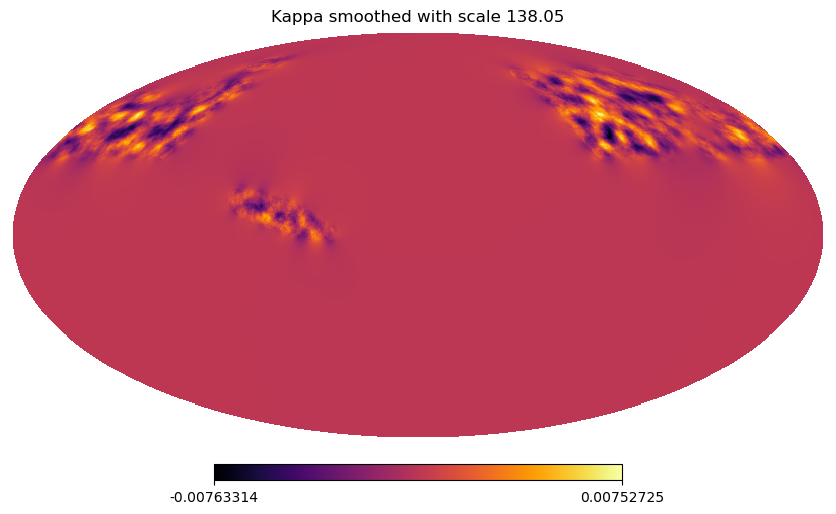

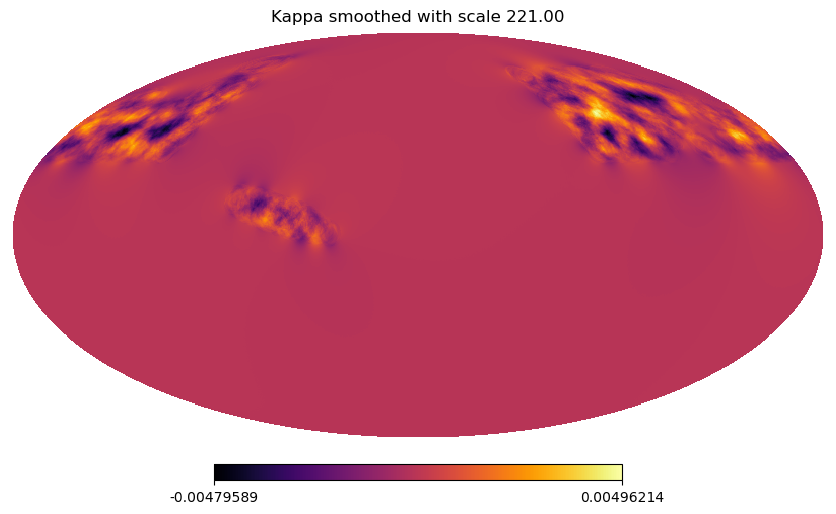

In [17]:
for i,scale in enumerate(smoothing_scales):
    hp.mollview(kappa_smooth[i], title=f'Kappa smoothed with scale {scale:.2f}', cmap='inferno')
    plt.show()

In [18]:
neighbour_array = np.empty((hp.nside2npix(nside), 8), dtype=int)
for i in range(hp.nside2npix(nside)):
    neighbour_array[i] = hp.get_all_neighbours(nside, i)

In [19]:
peaks_dict = dict()
peaks_dict_x = dict()
for map_, scale in tqdm(zip(kappa_smooth, smoothing_scales)):
    peaks_dict[int(scale)] = dict()
    peaks_dict_x[int(scale)] = dict()
    peak_loc = []
    for i in np.arange(hp.nside2npix(nside))[shear_map != 0]:
        if map_[i] > np.max(map_[neighbour_array[i]]):
            peak_loc.append(i)

8it [00:05,  1.52it/s]


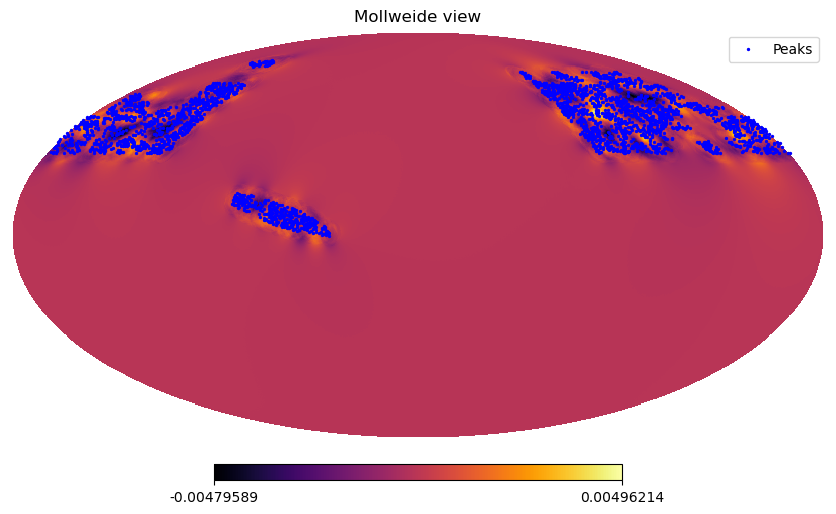

In [20]:
theta, phi = hp.pix2ang(nside, np.array(peak_loc))

hp.mollview(kappa_smooth[-1], "Peak counts on coarse map", cmap='inferno')

hp.projscatter(theta, phi, color="blue", s=2, label="Peaks")

plt.legend()
plt.show()

(array([ 12.,  29.,  37.,  84., 173., 396., 565., 645., 446., 264.,  84.,
         56.,  13.,  11.]),
 array([-0.0044233 , -0.0037433 , -0.0030633 , -0.00238331, -0.00170331,
        -0.00102331, -0.00034331,  0.00033668,  0.00101668,  0.00169668,
         0.00237668,  0.00305667,  0.00373667,  0.00441667,  0.00509667]),
 [<matplotlib.patches.Polygon at 0x7faa89a6c460>])

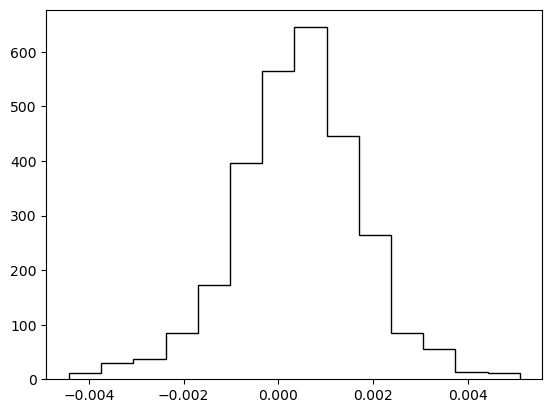

In [22]:
plt.figure()

plt.hist(kappa_smooth[-1][peak_loc], bins=14, histtype='step', color='black', label='Peaks')